In [1]:
import numpy as np
import pandas as pd
import plotnine as p9

import polygraph.input, polygraph.embedding, polygraph.motifs, polygraph.models, polygraph.sequence, polygraph.utils, polygraph.visualize, polygraph.stats

%matplotlib inline

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Read data

The input file should be a tab or comma separated file with two columns. The first column contains the sequence and the second contains the group. The `read_seqs` function will assign a unique ID to each sequence.

In [2]:
seqs = polygraph.input.read_seqs('yeast_seqs.txt', sep='\t')
seqs.head()

,SeqID,Sequence,Group
0,seq_0,GATGAGTGAAAAATCGTAATGAGTCAGCAAATCACTCTGTACGTTA...,native_high
1,seq_1,CATCGACTTATTTTTTTTTTTTGATGAAATTTTTCAGATTTTACAA...,native_high
2,seq_2,GCCTCTTATTTTTTTTTTTTTCGATTTTTGGCCCACAGGTCATATT...,native_high
3,seq_3,GATGAGTGAAAAATCGTAATGAGTCAGCAAATCACTGTGTACGTTA...,native_high
4,seq_4,AGAGCGACGCAAACAGCGCGCAGACTCTACGGGTAATAGACTCACA...,native_high


This dataset contains the sequences of 3929 native yeast promoters as well as 50 random sequences and 50 synthetic promoters each generated by evolution and gradient (Ledidi) methods starting from the random sequences.

In [3]:
print(seqs.Group.value_counts())

Group
native_high    50
native_low     50
random         50
evolution      50
gradient       50
Name: count, dtype: int64


# 1. Evaluate sequence content

## 1.1 GC content

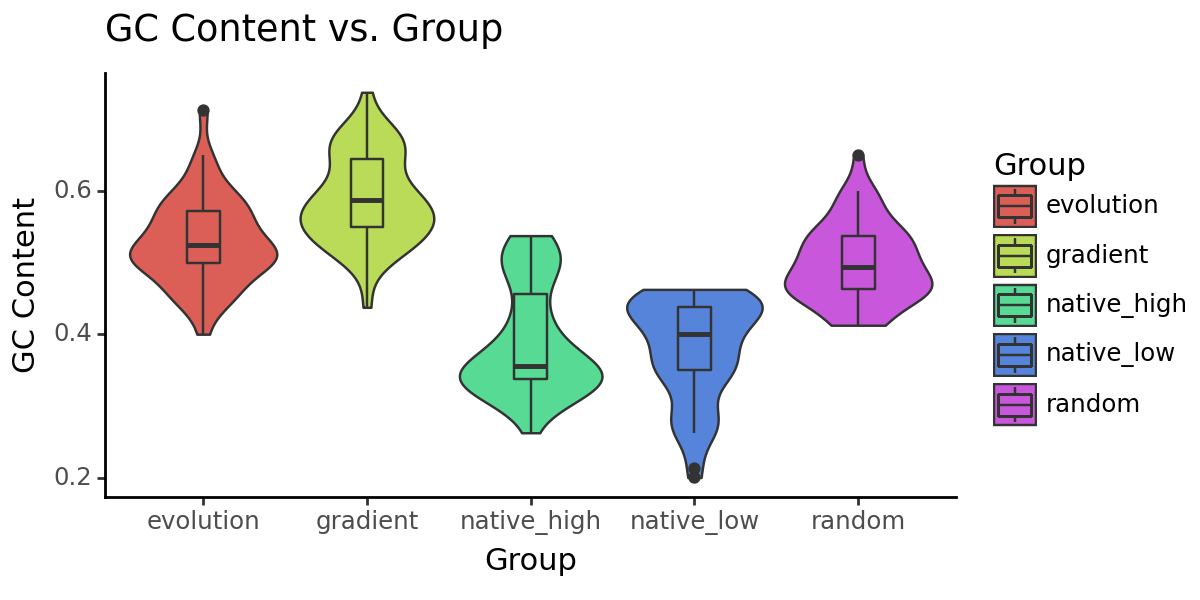

<Figure Size: (600 x 300)>

In [4]:
seqs['GC Content'] = polygraph.sequence.gc(seqs)
polygraph.visualize.boxplot(seqs, value_col='GC Content') + p9.theme(figure_size=(6,3))

In [5]:
polygraph.stats.kruskal_dunn(data=seqs, val_col="GC Content")

{'Kruskal': 2.6802086812745613e-33,
 'Dunn':                 evolution      gradient   native_high    native_low  \
 evolution    1.000000e+00  3.981474e-02  5.083945e-11  1.115903e-12   
 gradient     3.981474e-02  1.000000e+00  1.334155e-21  6.617939e-24   
 native_high  5.083945e-11  1.334155e-21  1.000000e+00  1.000000e+00   
 native_low   1.115903e-12  6.617939e-24  1.000000e+00  1.000000e+00   
 random       8.738300e-01  4.453899e-05  2.059939e-06  1.083978e-07   
 
                    random  
 evolution    8.738300e-01  
 gradient     4.453899e-05  
 native_high  2.059939e-06  
 native_low   1.083978e-07  
 random       1.000000e+00  }

## 1.2 length distribution

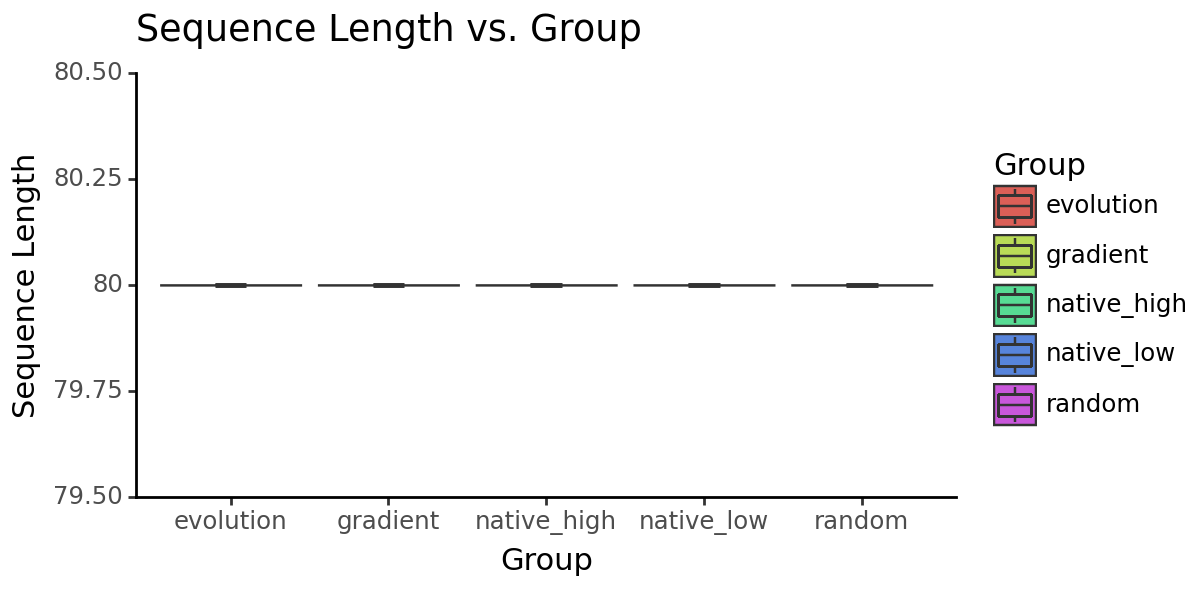

<Figure Size: (600 x 300)>

In [6]:
seqs['Sequence Length'] = seqs.Sequence.apply(len)
polygraph.visualize.boxplot(seqs, value_col='Sequence Length') + p9.theme(figure_size=(6,3))

## 1.3 k-mer content

In [7]:
%%time
kmers = polygraph.sequence.kmer_frequencies(seqs.Sequence.tolist(), k=5, normalize=True)

CPU times: user 371 ms, sys: 33.8 ms, total: 405 ms
Wall time: 383 ms


In [8]:
%%time
emb = polygraph.embedding.embedding_analysis(kmers, seqs, reference_group='native_high', use_pca=True)

Creating AnnData object
PCA


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


Fraction of variance explained:  [0.07 0.04 0.04 0.03 0.03 0.03 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
Fraction of total variance explained:  0.6727464259481488
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
CPU times: user 1min 1s, sys: 3.32 s, total: 1min 4s
Wall time: 7.44 s


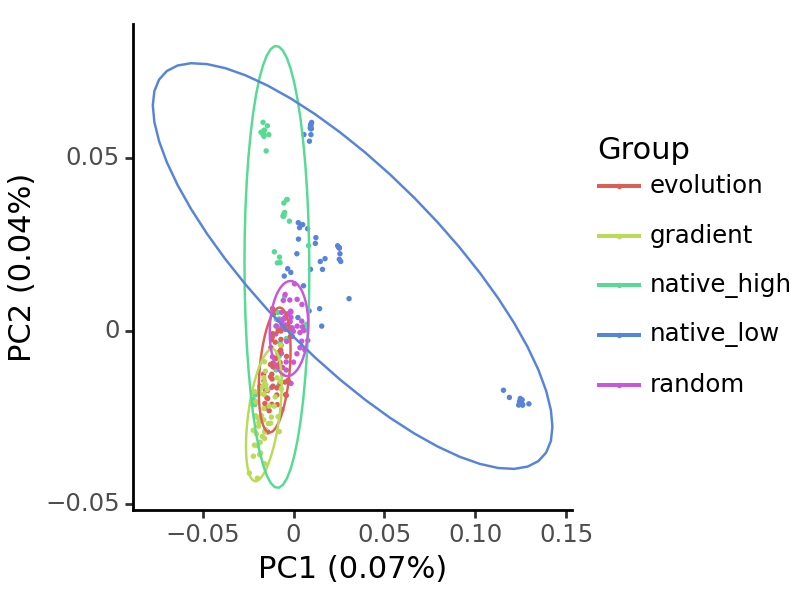

<Figure Size: (400 x 300)>

In [9]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(4,3))

In [10]:
# Differential k-mer abundance

print("Number of differential k-mers compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential k-mers")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head(10))

Number of differential k-mers compared to reference
Group
native_low    23
gradient      13
random         7
evolution      3
Name: count, dtype: int64

Top Differential k-mers
           Group  value     score          padj
1021    gradient  GCGCG  6.600832  4.174412e-08
2042  native_low  TTTTT -6.204438  5.604550e-07
3063      random  TTTTT -5.887322  4.007457e-06
1022    gradient  CGCGC  5.763233  4.212521e-06
2043  native_low  TTTTC -5.521950  1.711494e-05
2044  native_low  ATGAT  5.222069  6.021703e-05
1023    gradient  AATGA -4.998019  1.971284e-04
1024    gradient  CGCGT  4.922187  2.184486e-04
1026    gradient  CGCGG  4.653328  5.557974e-04
1025    gradient  TGAAA -4.653328  5.557974e-04


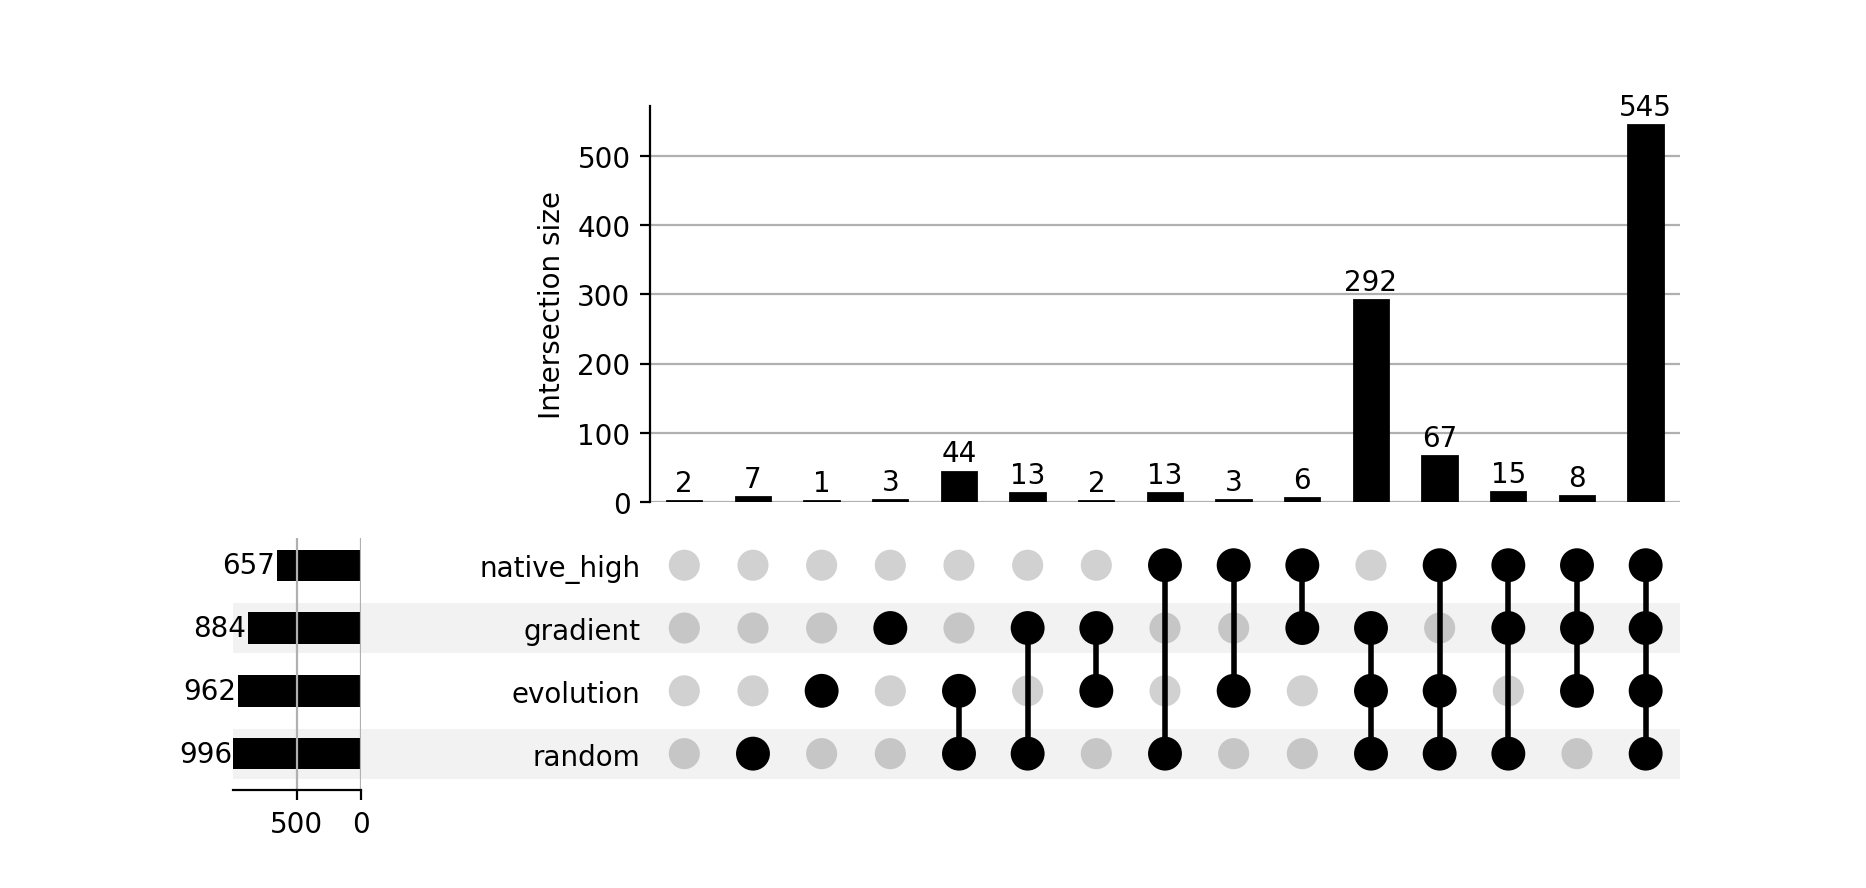

In [11]:
# kmer occurrence
polygraph.visualize.upset_plot(emb[emb.obs.Group!='native_low'])

In [12]:
# 1-NN statistics
print("Fraction of sequences by 1-NN group")
print(emb.uns["1NN_group_probs"])

print("")

print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

Fraction of sequences by 1-NN group
one_nn_group  evolution  gradient  native_high  native_low  random
Group                                                             
evolution          0.00      0.04         0.00        0.00    0.96
gradient           0.82      0.10         0.00        0.00    0.08
native_high        0.00      0.00         0.96        0.04    0.00
native_low         0.00      0.00         0.00        0.98    0.02
random             1.00      0.00         0.00        0.00    0.00

p-values for proportion of sequences with native nearest neighbor
            group_prop  ref_prop          pval          padj
Group                                                       
native_low         0.0      0.96  2.628570e-26  2.628570e-26
random             0.0      0.96  2.628570e-26  2.628570e-26
evolution          0.0      0.96  2.628570e-26  2.628570e-26
gradient           0.0      0.96  2.628570e-26  2.628570e-26


p-values for distance to closest reference
{'Kruskal': 5.87447378520593e-32, 'Dunn':                 evolution      gradient   native_high    native_low  \
evolution    1.000000e+00  1.000000e+00  2.482365e-11  5.718240e-06   
gradient     1.000000e+00  1.000000e+00  9.070450e-08  3.911049e-09   
native_high  2.482365e-11  9.070450e-08  1.000000e+00  3.353105e-32   
native_low   5.718240e-06  3.911049e-09  3.353105e-32  1.000000e+00   
random       1.000000e+00  1.372834e-01  2.183549e-15  1.486926e-03   

                   random  
evolution    1.000000e+00  
gradient     1.372834e-01  
native_high  2.183549e-15  
native_low   1.486926e-03  
random       1.000000e+00  }


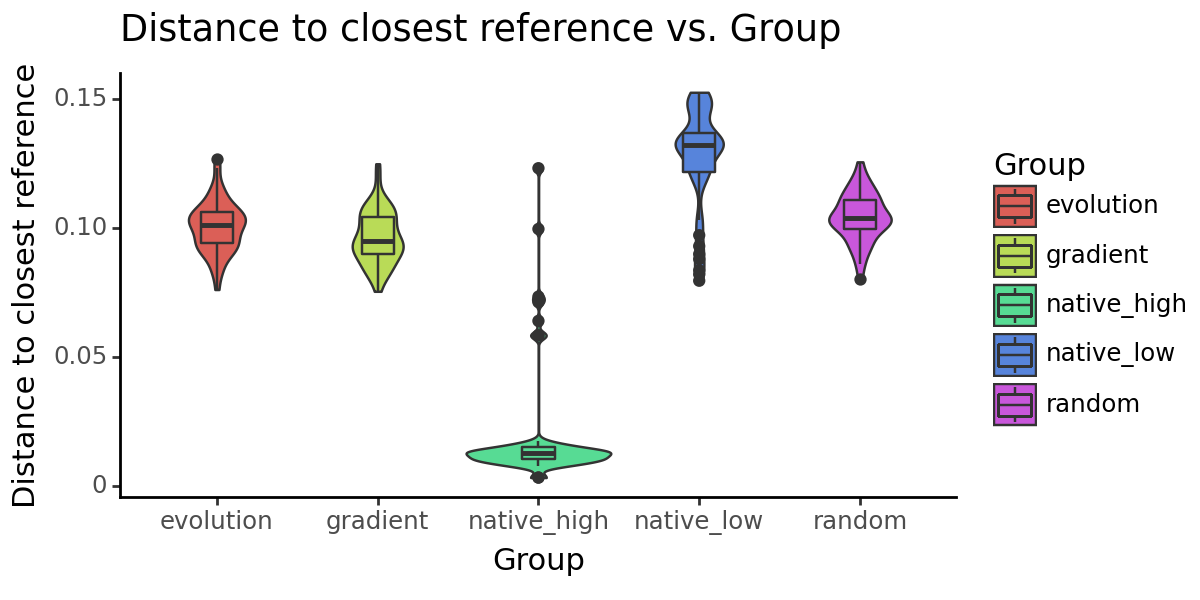

<Figure Size: (600 x 300)>

In [13]:
#Distance to reference
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6,3))

p-values for KNN diversity
{'Kruskal': 7.297512880047943e-20, 'Dunn':                 evolution      gradient  native_high    native_low  \
evolution    1.000000e+00  1.368051e-11     0.000001  1.391922e-13   
gradient     1.368051e-11  1.000000e+00     0.739896  1.000000e+00   
native_high  1.154417e-06  7.398956e-01     1.000000  1.655128e-01   
native_low   1.391922e-13  1.000000e+00     0.165513  1.000000e+00   
random       1.000000e+00  6.113697e-08     0.000565  1.332053e-09   

                   random  
evolution    1.000000e+00  
gradient     6.113697e-08  
native_high  5.650751e-04  
native_low   1.332053e-09  
random       1.000000e+00  }


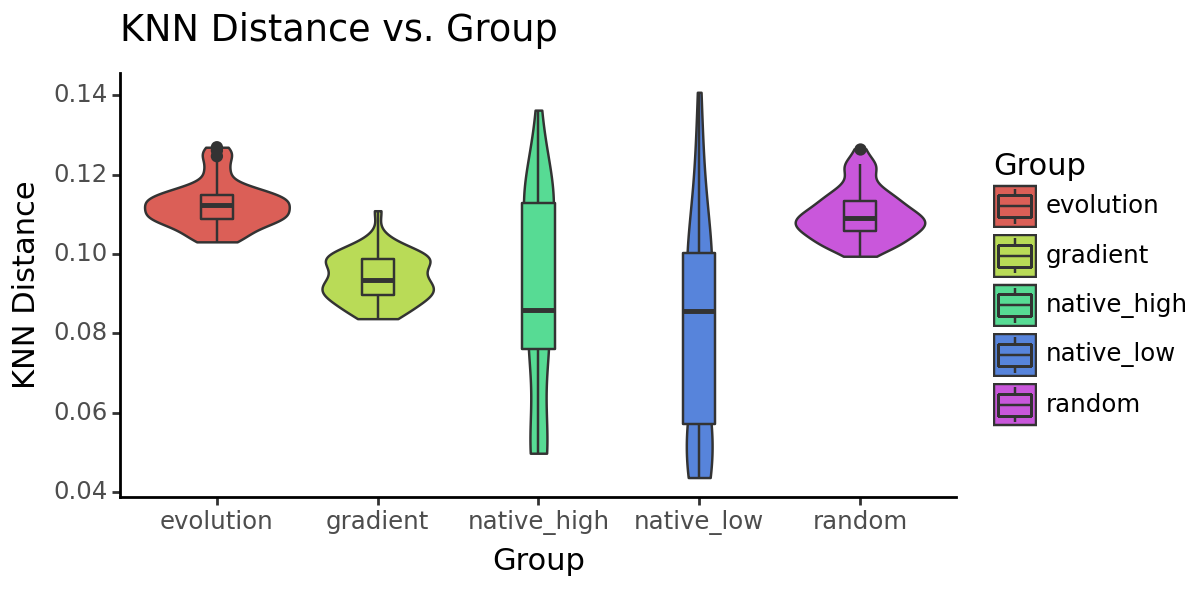

<Figure Size: (600 x 300)>

In [14]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6,3))

## 2. Motif content

In [15]:
yetfasco = polygraph.input.load_yetfasco()
len(yetfasco)

244

In [16]:
%%time
counts = polygraph.motifs.motif_frequencies(seqs, yetfasco, num_workers=8, normalize=True)

Processing motifs
Scanning
Assembling count matrix
CPU times: user 902 ms, sys: 516 ms, total: 1.42 s
Wall time: 25.5 s


In [17]:
meta = pd.read_table('yeast_motif_metadata.txt')
meta['MotifID'] = meta['Systematic Name'] + '_' + meta['Motif ID'].astype(str)
meta['New_MotifID'] = meta['Gene Name'] + '_' + meta['MotifID']

In [18]:
counts.columns = counts.columns.map(meta[['MotifID', 'New_MotifID']].set_index('MotifID').to_dict()['New_MotifID'])

In [19]:
counts = counts.loc[:, ~counts.columns.isna()]

In [20]:
%%time
emb = polygraph.embedding.embedding_analysis(counts, seqs, reference_group='native_high')

Creating AnnData object
PCA
Fraction of variance explained:  [0.24 0.04 0.04 0.03 0.03 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.   0.   0.   0.   0.  ]
Fraction of total variance explained:  0.8288272970247699
UMAP


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
CPU times: user 32.3 s, sys: 1.79 s, total: 34.1 s
Wall time: 1.09 s


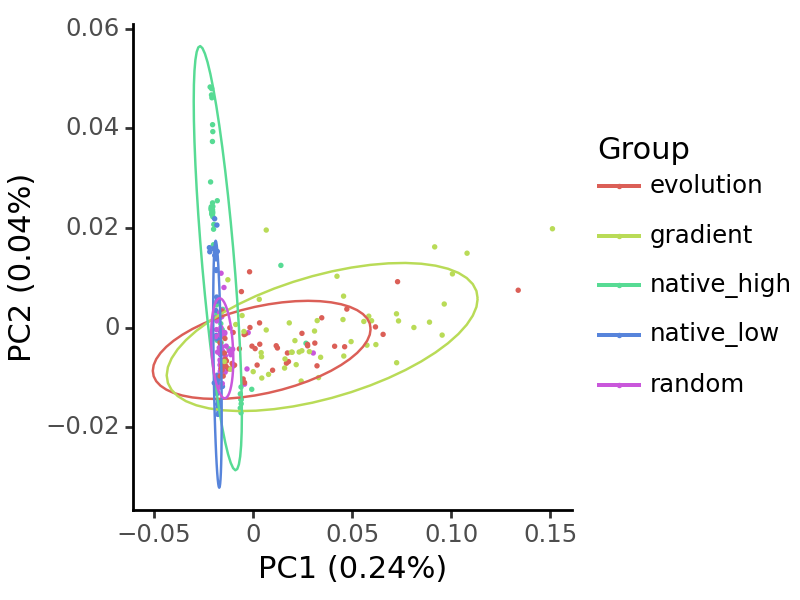

<Figure Size: (400 x 300)>

In [21]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(4,3))

In [22]:
# Differential motif abundance

print("Number of differential motifs compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential motifs")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head(10))

Number of differential motifs compared to reference
Group
gradient      13
evolution      3
native_low     2
random         1
Name: count, dtype: int64

Top Differential motifs
        Group                value     score          padj
223  gradient     MOT2_YER068W_556  6.121712  1.729203e-07
224  gradient    SPT15_YER148W_798  6.038986  1.729203e-07
225  gradient    NHP6A_YPR052C_879  5.425436  4.083888e-06
226  gradient  NHP6B_YBR089C-A_792  5.356498  4.083888e-06
227  gradient    PDC2_YDR081C_1050  5.342710  4.083888e-06
228  gradient    OTU1_YFL044C_1166  5.170365  8.683520e-06
229  gradient    WTM1_YOR230W_1148  4.346553  3.854928e-04
230  gradient     SUM1_YDR310C_478  4.346553  3.854928e-04
232  gradient    SIP4_YJL089W_2067 -3.963946  1.643974e-03
231  gradient     RLM1_YPL089C_419  3.984628  1.643974e-03


In [23]:
# 1-NN statistics
print("Fraction of sequences by 1-NN group")
print(emb.uns["1NN_group_probs"])

print("")

print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

Fraction of sequences by 1-NN group
one_nn_group  evolution  gradient  native_high  native_low  random
Group                                                             
evolution          0.18      0.20         0.04        0.02    0.56
gradient           0.50      0.34         0.02        0.04    0.10
native_high        0.04      0.00         0.88        0.00    0.08
native_low         0.00      0.00         0.06        0.84    0.10
random             0.72      0.02         0.02        0.02    0.22

p-values for proportion of sequences with native nearest neighbor
            group_prop  ref_prop          pval          padj
Group                                                       
native_low        0.06      0.88  7.441103e-18  7.441103e-18
random            0.02      0.88  2.592916e-20  5.185833e-20
evolution         0.04      0.88  5.327892e-19  7.103856e-19
gradient          0.02      0.88  2.592916e-20  5.185833e-20


p-values for distance to closest reference
{'Kruskal': 3.168810559342363e-27, 'Dunn':                 evolution      gradient   native_high    native_low  \
evolution    1.000000e+00  6.169124e-02  8.233869e-15  4.885755e-03   
gradient     6.169124e-02  1.000000e+00  3.866015e-26  4.797254e-09   
native_high  8.233869e-15  3.866015e-26  1.000000e+00  5.025223e-05   
native_low   4.885755e-03  4.797254e-09  5.025223e-05  1.000000e+00   
random       1.110176e-01  1.305064e-06  3.564043e-07  1.000000e+00   

                   random  
evolution    1.110176e-01  
gradient     1.305064e-06  
native_high  3.564043e-07  
native_low   1.000000e+00  
random       1.000000e+00  }


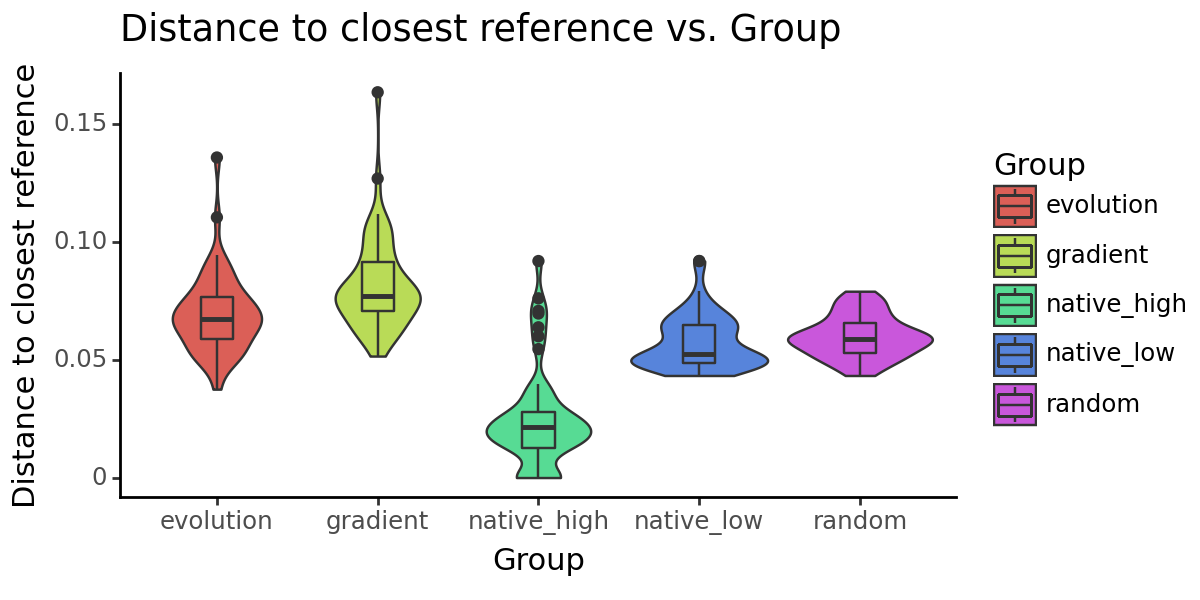

<Figure Size: (600 x 300)>

In [24]:
#Distance to reference
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6,3))

p-values for KNN diversity
{'Kruskal': 6.305927820777698e-26, 'Dunn':                 evolution      gradient   native_high    native_low  \
evolution    1.000000e+00  5.078759e-03  1.059816e-05  1.582348e-09   
gradient     5.078759e-03  1.000000e+00  6.446331e-16  5.408476e-22   
native_high  1.059816e-05  6.446331e-16  1.000000e+00  1.000000e+00   
native_low   1.582348e-09  5.408476e-22  1.000000e+00  1.000000e+00   
random       5.350688e-02  3.808175e-09  3.616498e-01  3.037388e-03   

                   random  
evolution    5.350688e-02  
gradient     3.808175e-09  
native_high  3.616498e-01  
native_low   3.037388e-03  
random       1.000000e+00  }


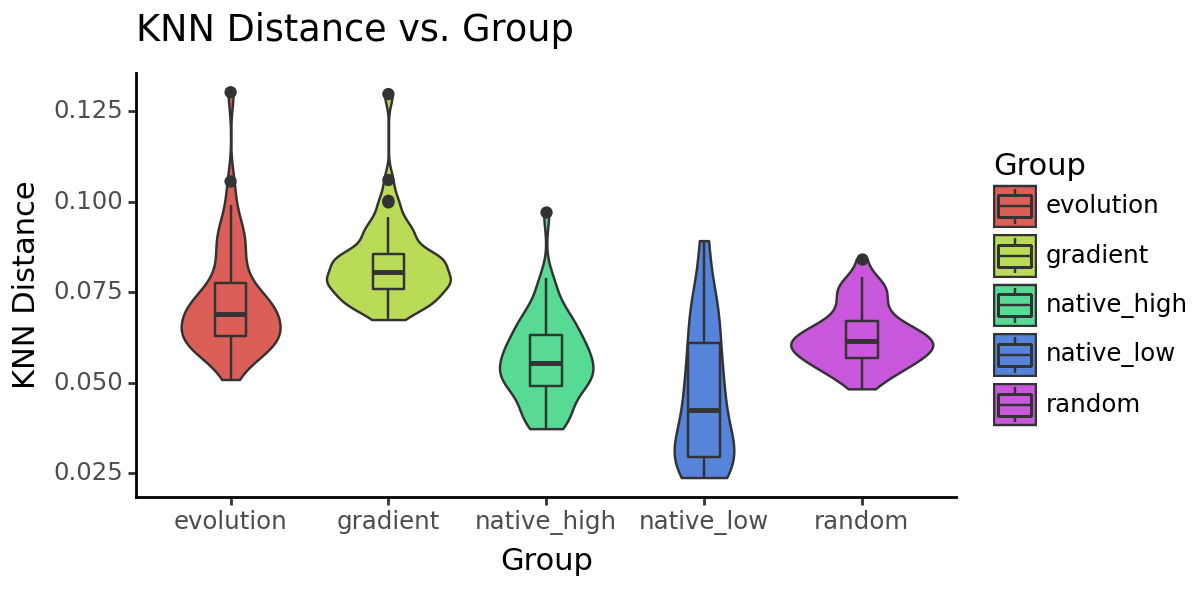

<Figure Size: (600 x 300)>

In [25]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6,3))

## 2.2 motif combinations

In [26]:
%%time
motif_combinations = polygraph.motifs.motif_combinations(
    counts, seqs, reference_group='native_high')

Listing motif combinations
Making count matrix
Filtering
Selected 336 combinations
Significance testing
CPU times: user 3.21 s, sys: 15.2 ms, total: 3.23 s
Wall time: 3.22 s


In [27]:
len(set(motif_combinations.combination))

145

In [28]:
motif_combinations.sort_values('padj').head(10)

,Group,group_prop,ref_prop,pval,padj,combination
1223,gradient,0.58,0.02,2.324297e-10,7.809637e-08,"(NHP6A_YPR052C_879, NHP6B_YBR089C-A_792)"
7,gradient,0.58,0.02,2.324297e-10,7.809637e-08,"(NHP6A_YPR052C_879, NHP6B_YBR089C-A_792)"
1227,gradient,0.58,0.02,2.324297e-10,7.809637e-08,"(NHP6A_YPR052C_879, NHP6B_YBR089C-A_792)"
215,gradient,0.58,0.02,2.324297e-10,7.809637e-08,"(NHP6A_YPR052C_879, NHP6B_YBR089C-A_792)"
355,gradient,0.50,0.00,1.042479e-09,2.335153e-07,"(SPT15_YER148W_798, PDC2_YDR081C_1050)"
11,gradient,0.50,0.00,1.042479e-09,2.335153e-07,"(SPT15_YER148W_798, PDC2_YDR081C_1050)"
731,gradient,0.48,0.00,3.047246e-09,3.150383e-07,"(MOT2_YER068W_556, WTM1_YOR230W_1148)"
31,gradient,0.48,0.00,3.047246e-09,3.150383e-07,"(MOT2_YER068W_556, WTM1_YOR230W_1148)"
1255,gradient,0.48,0.00,3.047246e-09,3.150383e-07,"(MOT2_YER068W_556, WTM1_YOR230W_1148)"
707,gradient,0.48,0.00,3.047246e-09,3.150383e-07,"(SPT15_YER148W_798, WTM1_YOR230W_1148)"


In [29]:
# Are there any significant motif combinations where neither individual motif is significant?
sig_motifs = emb.uns["DE_test"][emb.uns["DE_test"].padj < .01].value.tolist()
sig_combs = motif_combinations[motif_combinations['padj'] < .01]
sig_combs = sig_combs[sig_combs.combination.apply(lambda c: (c[0] not in sig_motifs) and (c[1] not in sig_motifs))]

In [30]:
sig_combs[sig_combs.Group=='evolution']

,Group,group_prop,ref_prop,pval,padj,combination
138,evolution,0.36,0.04,0.000088,0.000649,"(MIG3_YER028C_2144, MIG1_YGL035C_2142)"
158,evolution,0.00,0.32,0.000007,0.000100,"(HAP1_YLR256W_2078, PPR1_YLR014C_2064)"
210,evolution,0.00,0.28,0.000042,0.000321,"(ARG81_YML099C_1506, XBP1_YIL101C_2039)"
234,evolution,0.00,0.28,0.000042,0.000321,"(SIP4_YJL089W_573, PPR1_YLR014C_2064)"
246,evolution,0.02,0.28,0.000388,0.001717,"(GAL4_YPL248C_2206, XBP1_YIL101C_2039)"
250,evolution,0.00,0.28,0.000042,0.000321,"(HAP1_YLR256W_2078, XBP1_YIL101C_2039)"
258,evolution,0.00,0.28,0.000042,0.000321,"(XBP1_YIL101C_2039, PPR1_YLR014C_2064)"
294,evolution,0.00,0.26,0.000100,0.000658,"(ARG81_YML099C_1506, HAP1_YLR256W_2078)"
302,evolution,0.00,0.26,0.000100,0.000658,"(ARG81_YML099C_1506, PPR1_YLR014C_2064)"
346,evolution,0.00,0.24,0.000231,0.001186,"(GAL4_YPL248C_2206, ARG5,6_YER069W_1426)"


## 2.3 motif positions

In [31]:
# Select the TF motif most enriched in synthetic sequences
emb.uns['DE_test'].sort_values('padj').head()

,Group,value,score,padj
223,gradient,MOT2_YER068W_556,6.121712,1.729203e-07
224,gradient,SPT15_YER148W_798,6.038986,1.729203e-07
226,gradient,NHP6B_YBR089C-A_792,5.356498,4.083888e-06
225,gradient,NHP6A_YPR052C_879,5.425436,4.083888e-06
227,gradient,PDC2_YDR081C_1050,5.342710,4.083888e-06


In [32]:
%%time
sites = polygraph.motifs.scan_seqs(seqs, [m for m in yetfasco if m.name=="YBR089C-A_792"], num_workers=8)
sites.head()

Processing motifs
Scanning
CPU times: user 113 ms, sys: 369 ms, total: 482 ms
Wall time: 678 ms


,MotifID,score,start,end,SeqID,Group
0,YBR089C-A_792,9.778108,1.0,21.0,seq_30,native_high
1,YBR089C-A_792,9.909392,3.0,23.0,seq_30,native_high
2,YBR089C-A_792,8.213082,4.0,24.0,seq_135,random
3,YBR089C-A_792,9.896910,6.0,26.0,seq_135,random
4,YBR089C-A_792,8.844206,8.0,28.0,seq_135,random


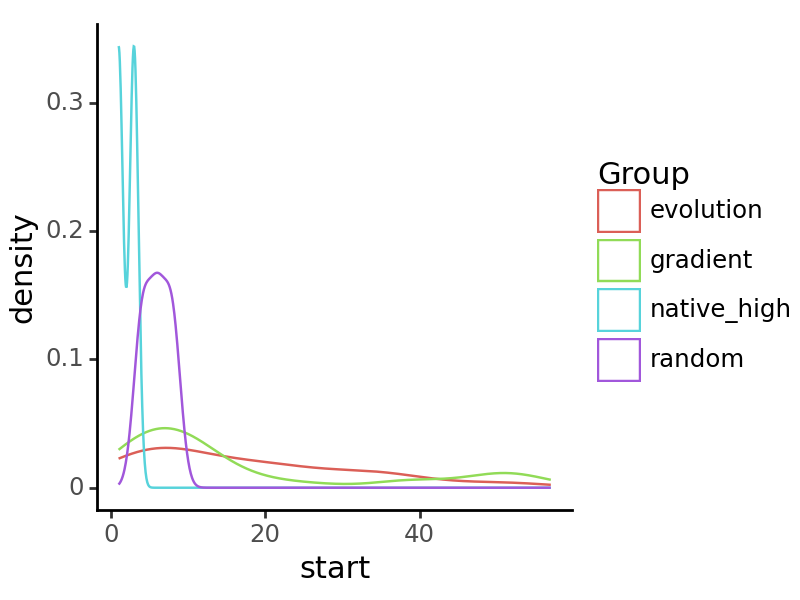

<Figure Size: (400 x 300)>

In [33]:
polygraph.visualize.densityplot(sites, value_col='start') + p9.theme(figure_size=(4,3))

In [34]:
polygraph.stats.kruskal_dunn(sites, val_col='start')

{'Kruskal': 0.09974405273736363,
 'Dunn':              evolution  gradient  native_high  random
 evolution     1.000000  1.000000     0.179778     1.0
 gradient      1.000000  1.000000     0.266906     1.0
 native_high   0.179778  0.266906     1.000000     1.0
 random        1.000000  1.000000     1.000000     1.0}

## 2.4 NMF

In [35]:
%%time
W, H, p = polygraph.motifs.nmf(counts, seqs, reference_group='native_high', n_components=10)

CPU times: user 18 s, sys: 789 ms, total: 18.8 s
Wall time: 166 ms


In [36]:
p[p.padj < .001]

,group,pval,padj,factor
2,evolution,1.260355e-05,5.601577e-05,factor_0
3,gradient,2.182810e-11,4.365619e-10,factor_0
1,random,1.675257e-05,6.701028e-05,factor_2
3,gradient,3.766204e-08,2.510803e-07,factor_2
0,native_low,3.447353e-09,2.757883e-08,factor_3
3,gradient,2.462749e-04,8.955452e-04,factor_4
1,random,1.479796e-07,8.455980e-07,factor_5
2,evolution,9.783558e-10,9.783558e-09,factor_5
3,gradient,9.754761e-12,3.901904e-10,factor_5
2,evolution,9.630350e-07,4.815175e-06,factor_7


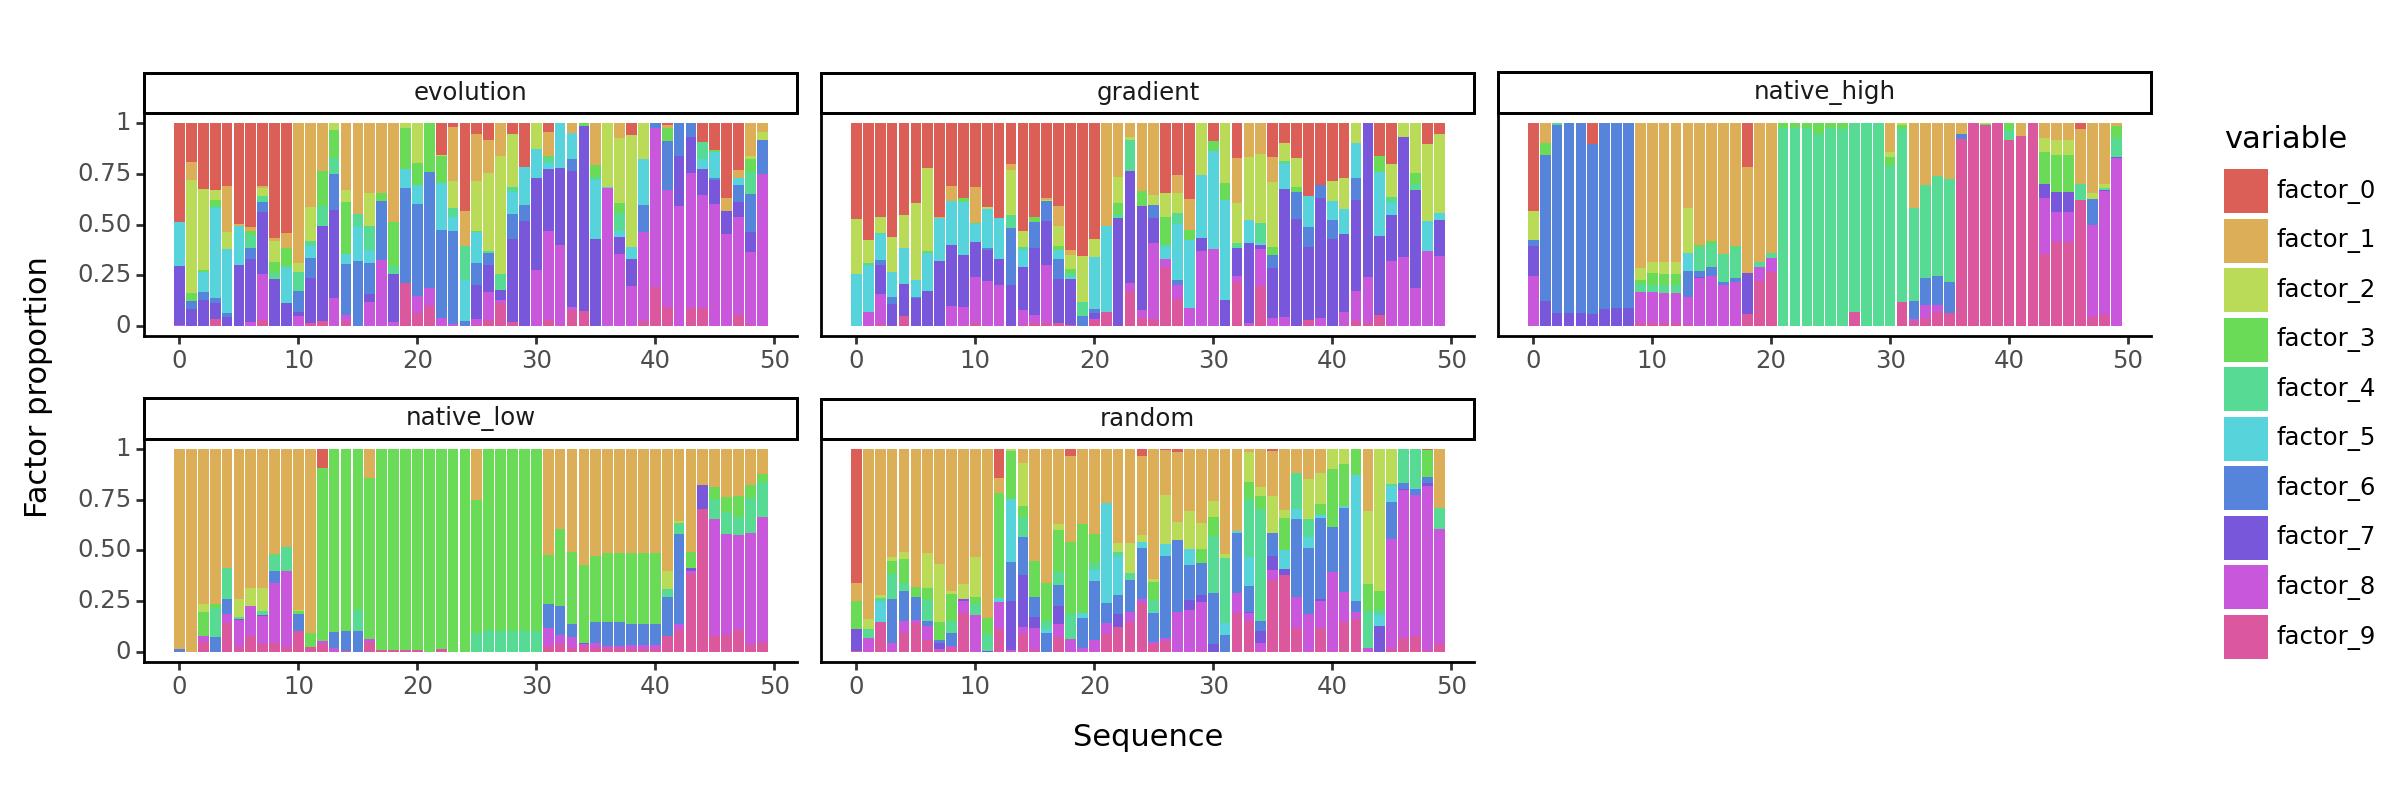

<Figure Size: (1200 x 400)>

In [37]:
polygraph.visualize.plot_seqs_nmf(W) + p9.theme(figure_size=(12, 4))

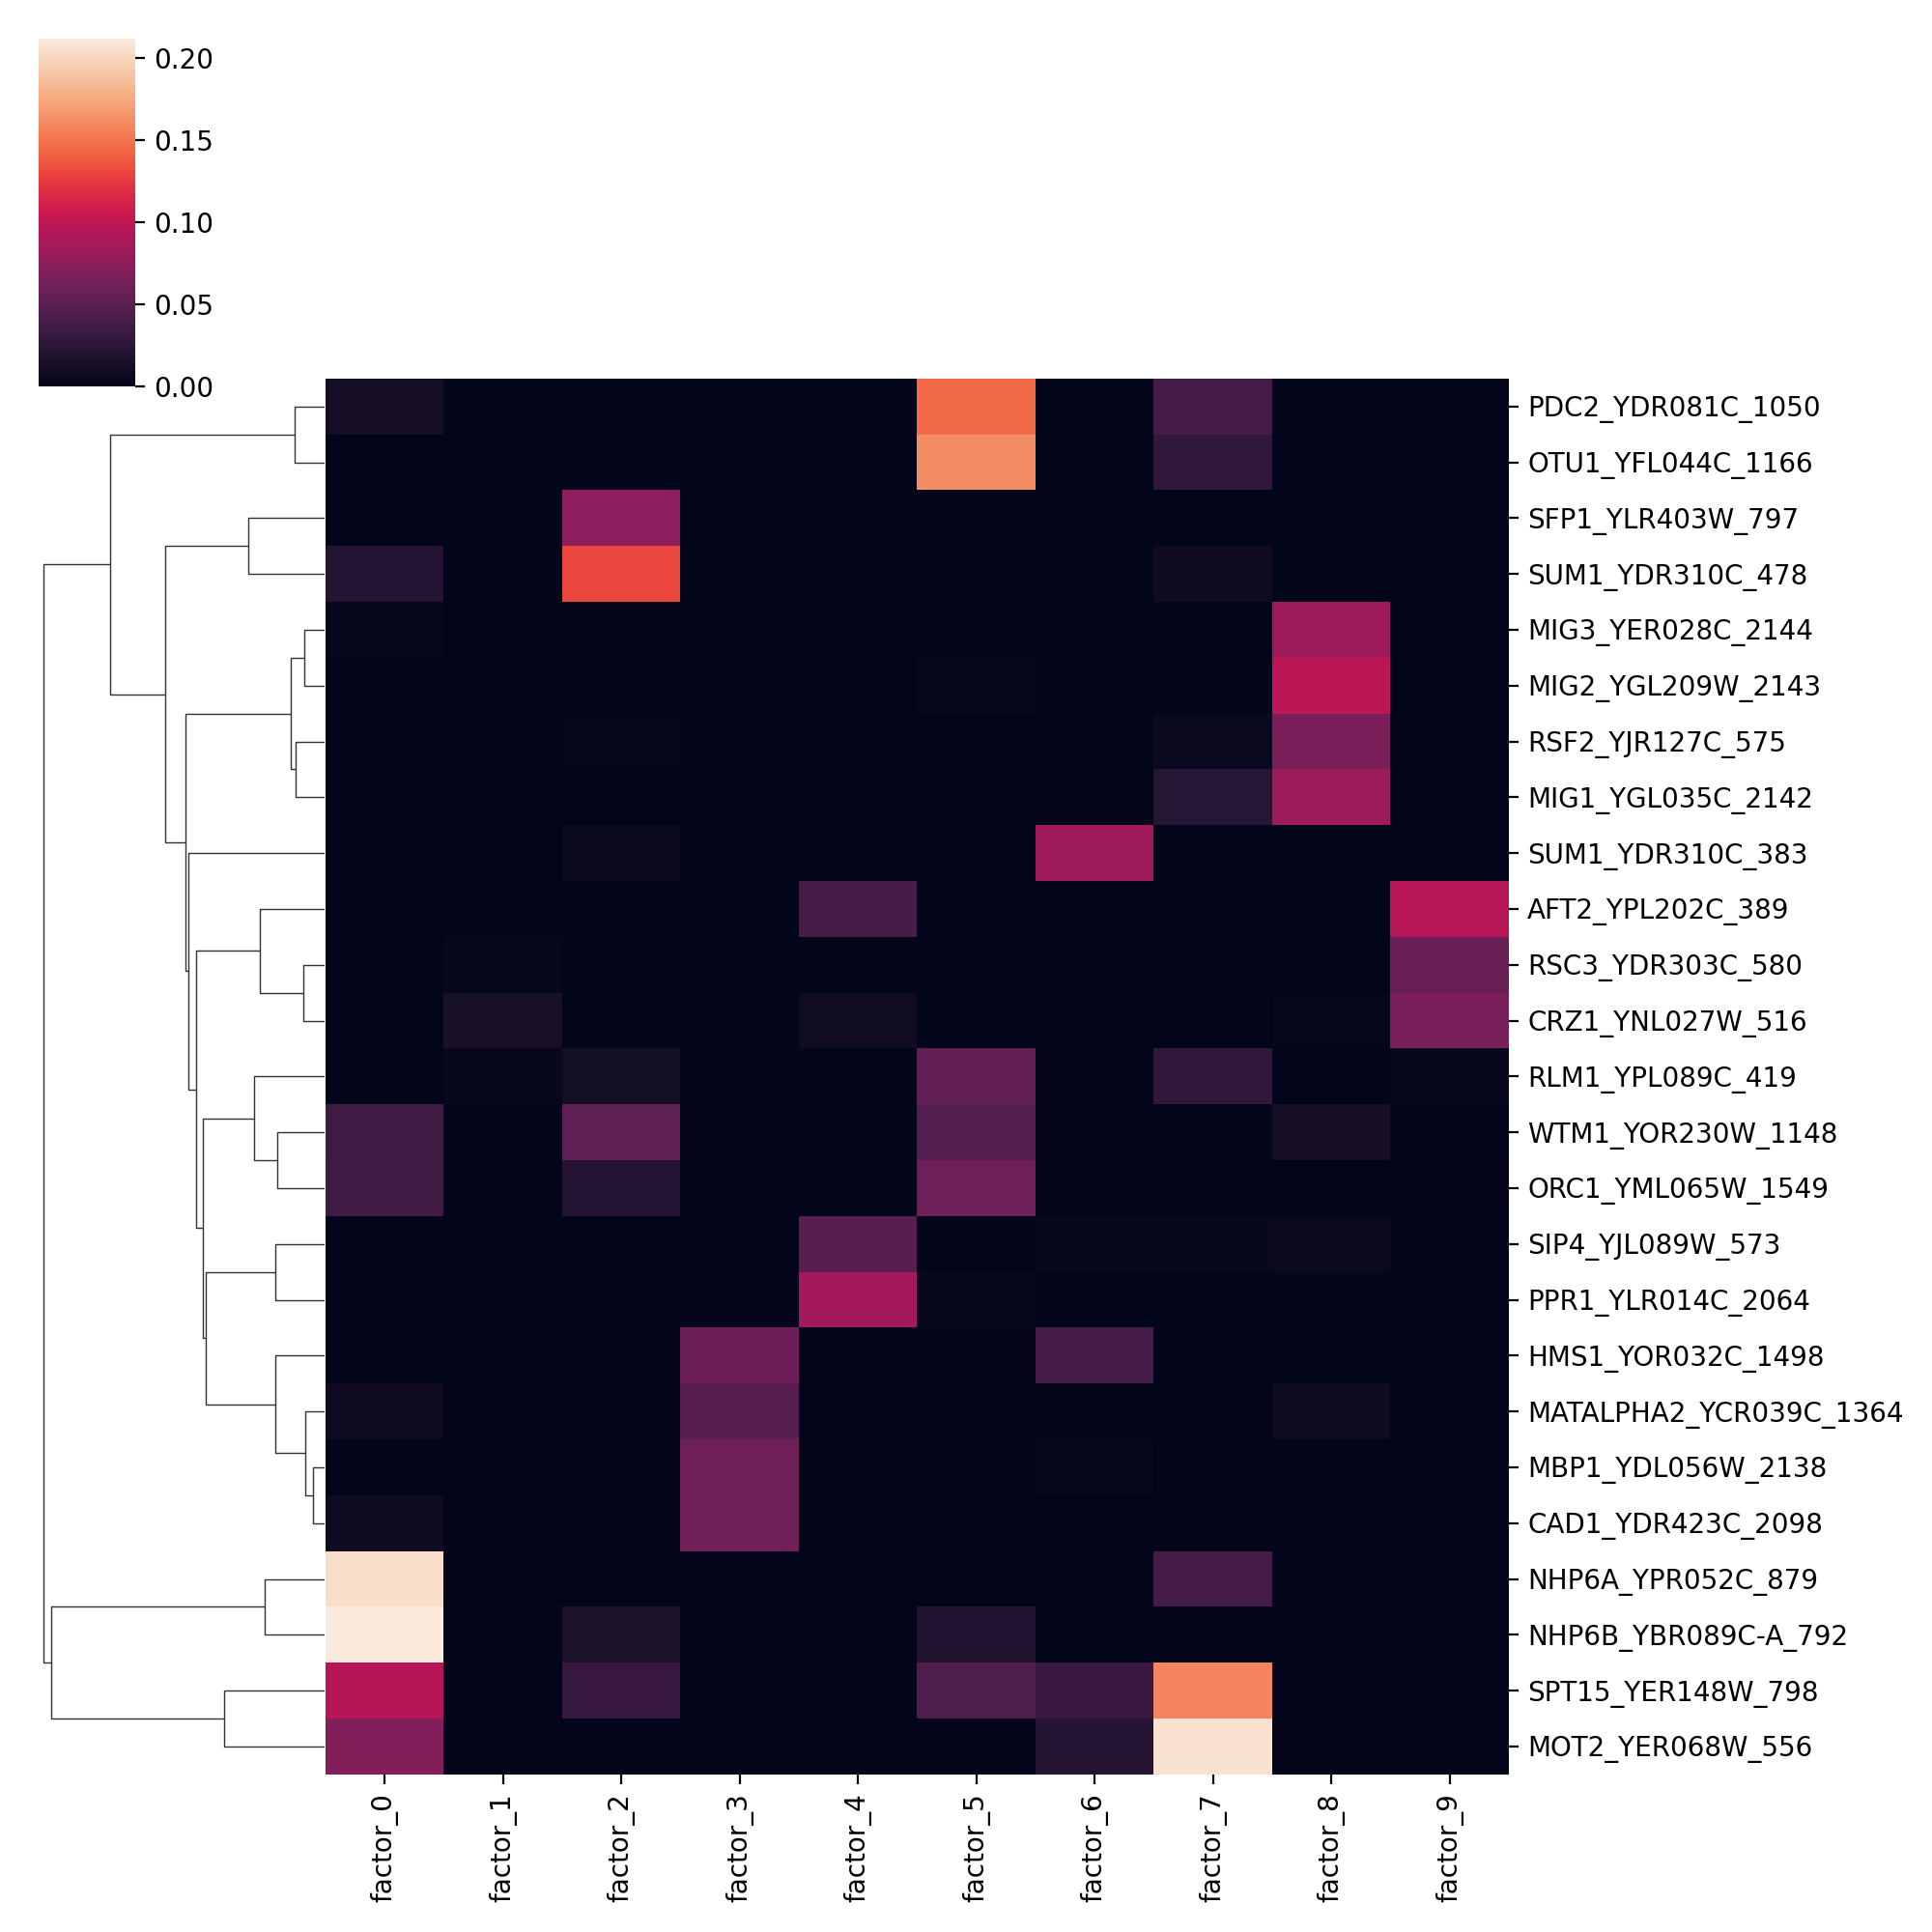

In [38]:
polygraph.visualize.plot_factors_nmf(H, n_features=25)

# 3. Model predictions

## 3.1 predictions

In [39]:
# Download yeast sequence-to-promoter activity model
!wget https://zenodo.org/records/10214625/files/yeast-model.pth

--2023-12-05 23:27:46--  https://zenodo.org/records/10214625/files/yeast-model.pth
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.185.79.172, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9968513 (9.5M) [application/octet-stream]
Saving to: ‘yeast-model.pth’

yeast-model.pth     100%[===================>]   9.51M  6.38MB/s    in 1.5s    

2023-12-05 23:27:48 (6.38 MB/s) - ‘yeast-model.pth’ saved [9968513/9968513]



In [40]:
import torch
model = torch.load('yeast-model.pth')

In [41]:
seqs[['complex_pred', 'defined_pred']] = polygraph.models.predict(model, seqs, batch_size=512)

Padding all sequences to length 80


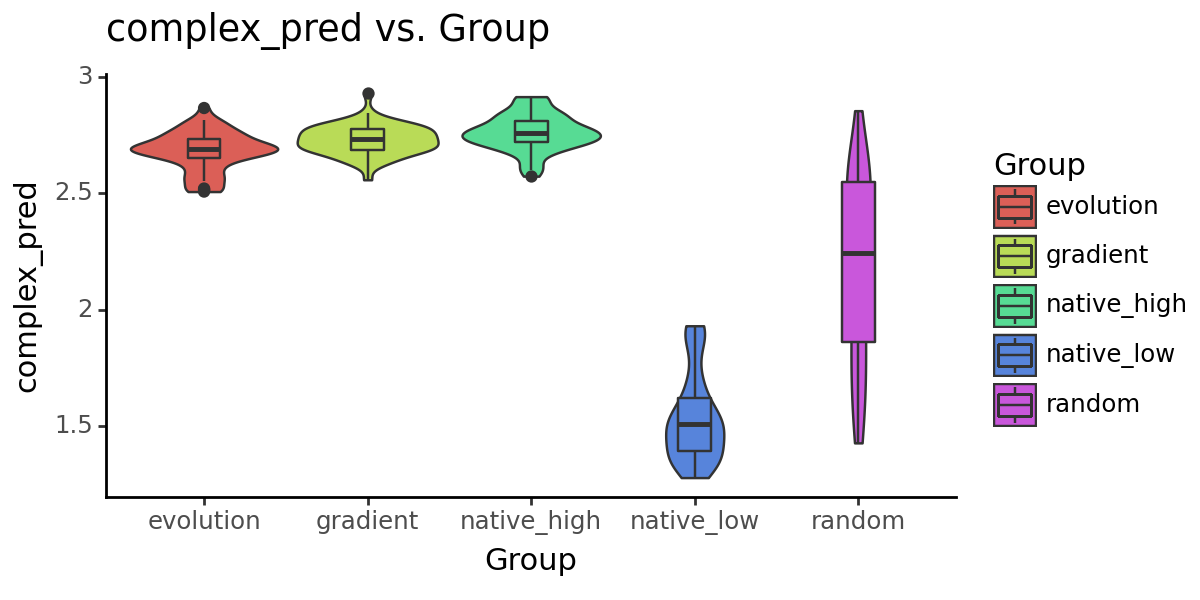

<Figure Size: (600 x 300)>

In [42]:
polygraph.visualize.boxplot(seqs, value_col='complex_pred') + p9.theme(figure_size=(6, 3))

## 3.2 cell type specificity

In [43]:
seqs[['mingap', 'meangap', 'maxgap']] = polygraph.models.cell_type_specificity(seqs.complex_pred, [seqs.defined_pred])

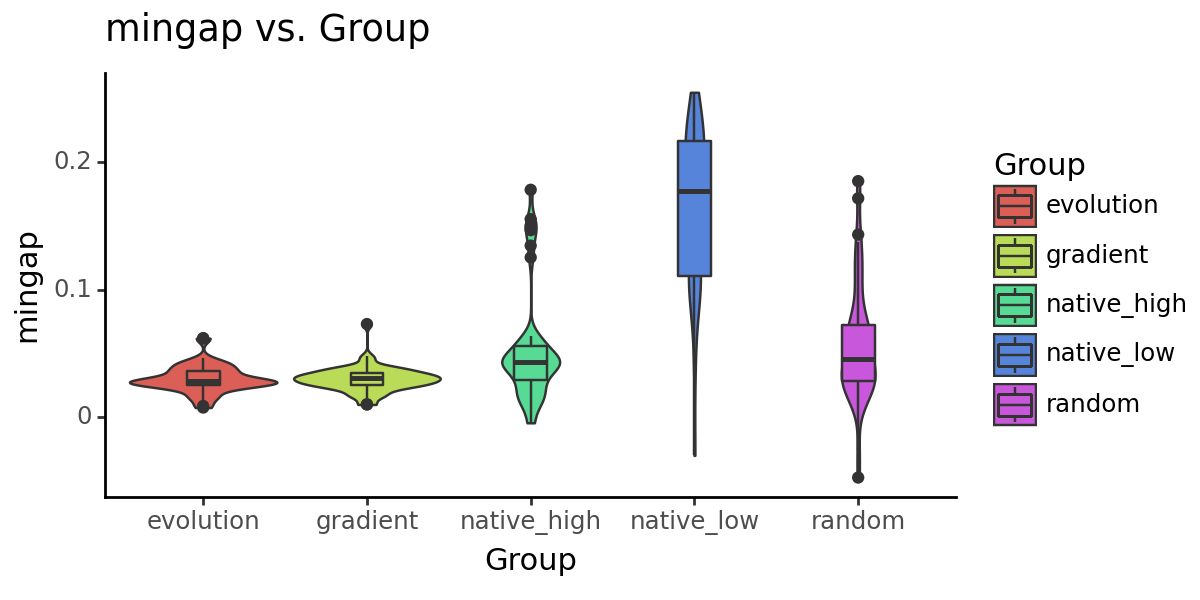

<Figure Size: (600 x 300)>

In [44]:
polygraph.visualize.boxplot(seqs, value_col='mingap') + p9.theme(figure_size=(6, 3))

## 3.3 Model embeddings

In [45]:
%%time
emb = polygraph.models.get_embeddings(seqs, model, batch_size=512, drop_last_layers=4)

Padding all sequences to length 80
CPU times: user 4.72 s, sys: 889 ms, total: 5.61 s
Wall time: 47.1 ms


In [46]:
emb = polygraph.embedding.embedding_analysis(emb, seqs, reference_group='native_high')

Creating AnnData object
PCA
Fraction of variance explained:  [0.79 0.06 0.04 0.02 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
Fraction of total variance explained:  0.9960335
UMAP


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference


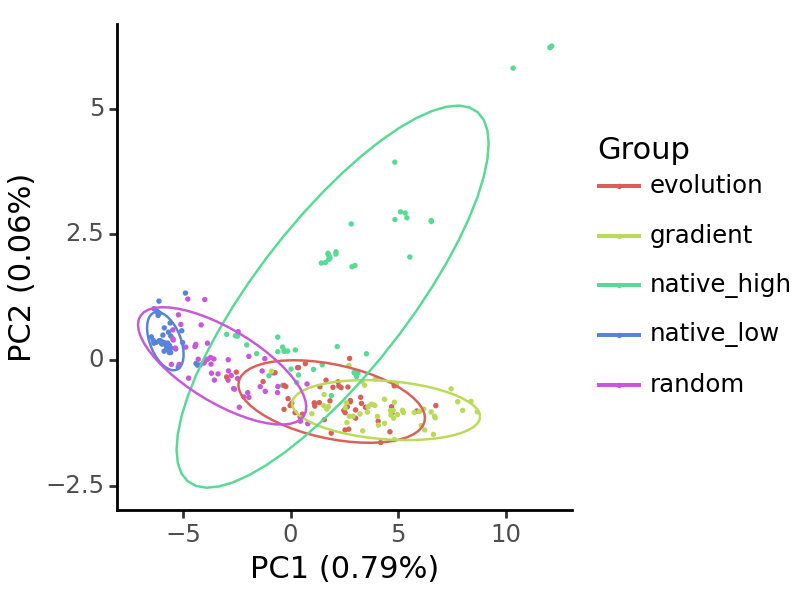

<Figure Size: (400 x 300)>

In [47]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(4, 3))

In [48]:
# 1-NN statistics
print(emb.uns["1NN_group_probs"])
print(emb.uns["1NN_ref_prop_test"])

one_nn_group  evolution  gradient  native_high  native_low  random
Group                                                             
evolution          0.46      0.42         0.02        0.00    0.10
gradient           0.38      0.60         0.00        0.00    0.02
native_high        0.10      0.02         0.86        0.00    0.02
native_low         0.00      0.00         0.00        0.88    0.12
random             0.20      0.06         0.00        0.14    0.60
            group_prop  ref_prop          pval          padj
Group                                                       
native_low        0.00      0.86  5.241001e-21  6.988002e-21
random            0.00      0.86  5.241001e-21  6.988002e-21
evolution         0.02      0.86  2.029279e-19  2.029279e-19
gradient          0.00      0.86  5.241001e-21  6.988002e-21


{'Kruskal': 2.348966769780271e-33, 'Dunn':                 evolution      gradient   native_high    native_low  \
evolution    1.000000e+00  8.489382e-04  1.040294e-04  3.981644e-13   
gradient     8.489382e-04  1.000000e+00  7.506634e-16  2.818386e-03   
native_high  1.040294e-04  7.506634e-16  1.000000e+00  5.089563e-32   
native_low   3.981644e-13  2.818386e-03  5.089563e-32  1.000000e+00   
random       8.689547e-01  2.654523e-01  9.320576e-09  4.927982e-08   

                   random  
evolution    8.689547e-01  
gradient     2.654523e-01  
native_high  9.320576e-09  
native_low   4.927982e-08  
random       1.000000e+00  }


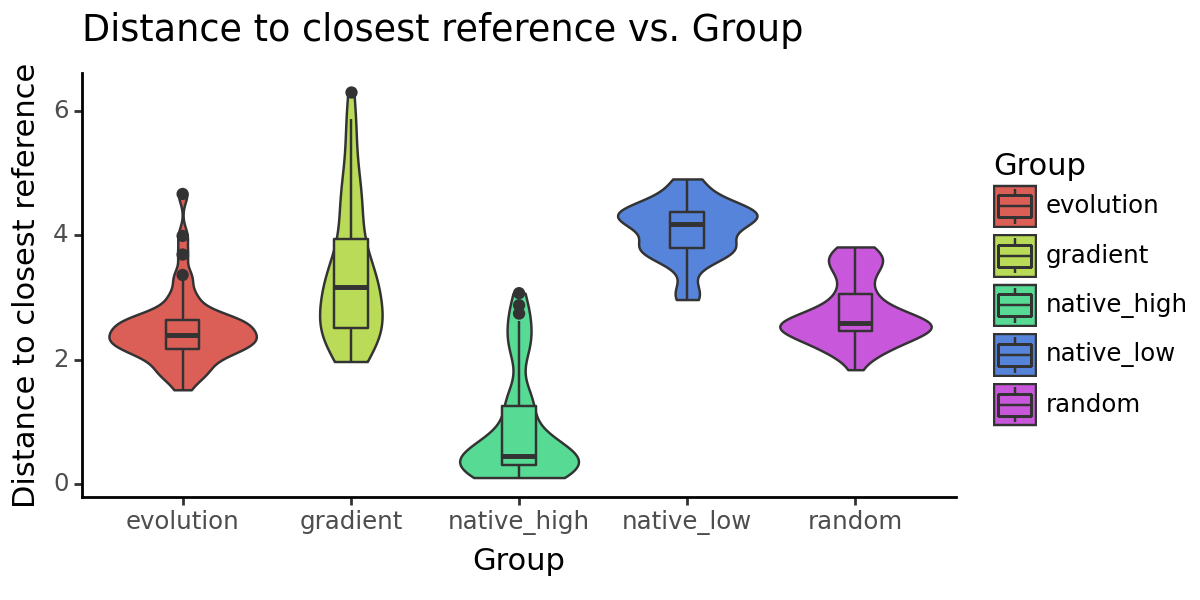

<Figure Size: (600 x 300)>

In [49]:
#Distance to reference
print(emb.uns['ref_dist_test'])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6, 3))

{'Kruskal': 1.0994738008634255e-24, 'Dunn':                 evolution      gradient   native_high    native_low  \
evolution    1.000000e+00  8.167593e-01  1.121763e-02  3.283308e-12   
gradient     8.167593e-01  1.000000e+00  5.759714e-06  3.004181e-07   
native_high  1.121763e-02  5.759714e-06  1.000000e+00  5.632045e-25   
native_low   3.283308e-12  3.004181e-07  5.632045e-25  1.000000e+00   
random       1.000000e+00  1.000000e+00  2.729184e-03  5.179716e-11   

                   random  
evolution    1.000000e+00  
gradient     1.000000e+00  
native_high  2.729184e-03  
native_low   5.179716e-11  
random       1.000000e+00  }


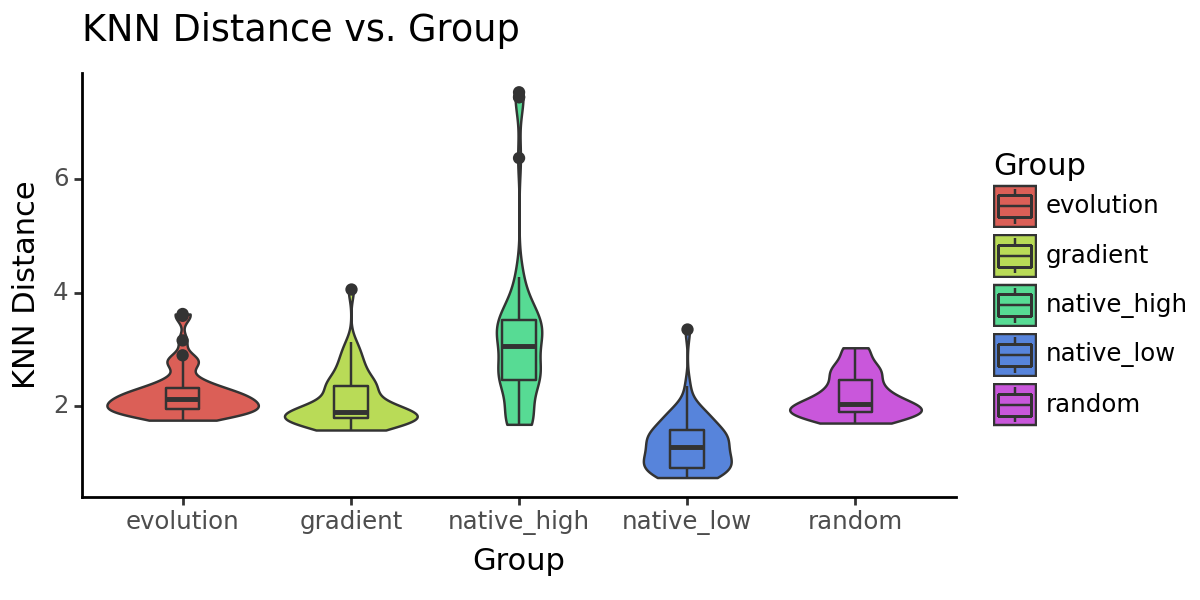

<Figure Size: (600 x 300)>

In [50]:
# KNN distance (diversity metric)
print(emb.uns['knn_dist_test'])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6,3))

## 3.4 edit distance to closest native sequence 

In [51]:
%%time
seqs['edit'] = polygraph.sequence.min_edit_distance_from_reference(seqs, reference_group='native_high')

CPU times: user 39.8 ms, sys: 0 ns, total: 39.8 ms
Wall time: 38.7 ms


{'Kruskal': 5.923511583752835e-28, 'Dunn':                 evolution      gradient   native_high    native_low  \
evolution    1.000000e+00  1.000000e+00  6.808805e-19  1.714780e-01   
gradient     1.000000e+00  1.000000e+00  1.451053e-21  2.468244e-02   
native_high  6.808805e-19  1.451053e-21  1.000000e+00  1.507995e-10   
native_low   1.714780e-01  2.468244e-02  1.507995e-10  1.000000e+00   
random       1.000000e+00  1.000000e+00  7.336593e-20  8.750129e-02   

                   random  
evolution    1.000000e+00  
gradient     1.000000e+00  
native_high  7.336593e-20  
native_low   8.750129e-02  
random       1.000000e+00  }


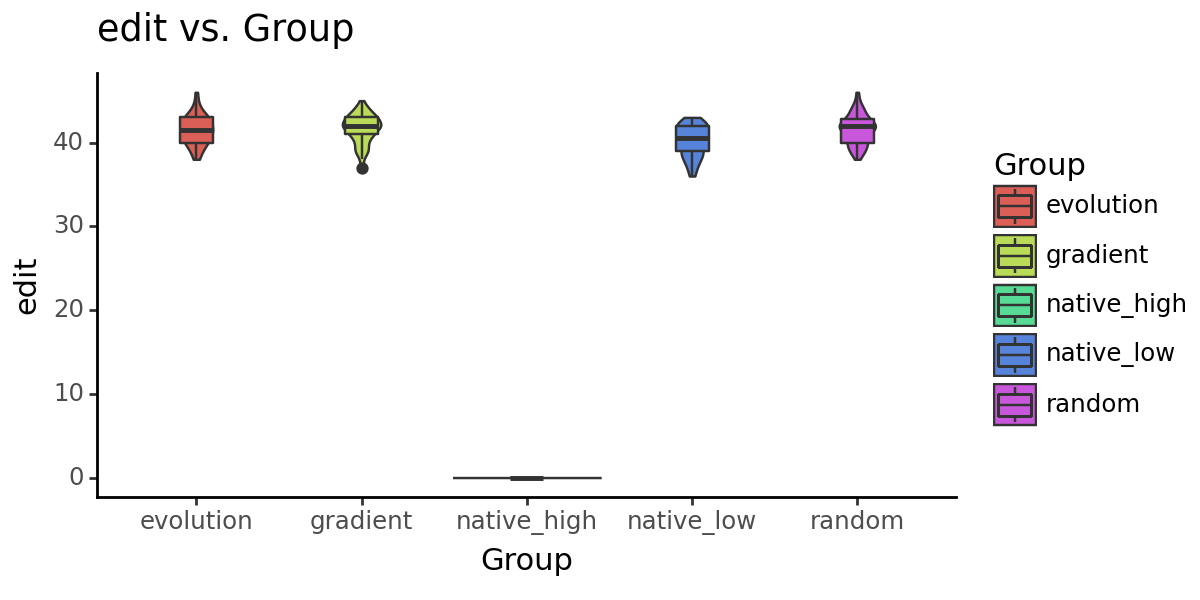

<Figure Size: (600 x 300)>

In [52]:
print(polygraph.stats.kruskal_dunn(seqs[seqs.Group!='native'], val_col='edit'))
polygraph.visualize.boxplot(seqs, value_col='edit') + p9.theme(figure_size=(6, 3))